In [1]:
import rasterio
from rasterio.plot import show
import rasterio.warp
import rasterio.mask
import shapely.geometry
from affine import Affine
import warnings
import time
import os

RASTERIO_BEST_PRACTICES = dict(  # See https://github.com/pangeo-data/cog-best-practices
    CURL_CA_BUNDLE="/etc/ssl/certs/ca-certificates.crt",
    GDAL_DISABLE_READDIR_ON_OPEN="EMPTY_DIR",
    AWS_NO_SIGN_REQUEST="YES",
    GDAL_MAX_RAW_BLOCK_CACHE_SIZE="200000000",
    GDAL_SWATH_SIZE="200000000",
    VSI_CURL_CACHE_SIZE="200000000",
)
os.environ.update(RASTERIO_BEST_PRACTICES)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.colors as colors

import geopandas
from osgeo import gdal

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [2]:
year = 2014
cell_size = 5000
geodetic_epsg = 'EPSG:4326'
projected_epsg = 'EPSG:20935' 
country_code = 'ZMB' # 'TZA' # 'NGA'
taylor_data_dir = "/capstone/cropmosaiks/data"  

In [3]:
africa = geopandas.read_file(taylor_data_dir+'/boundaries/africa_adm0.geojson')
country = africa[africa.adm0_a3 == country_code]

# Project country into local EPSG with units in meters
country_prj = country.to_crs(projected_epsg)

# Create grid of points
xmin, ymin, xmax, ymax = country_prj.total_bounds
xs = list(np.arange(xmin, xmax + cell_size, cell_size))
ys = list(np.arange(ymin, ymax + cell_size, cell_size))
def make_cell(x, y, cell_size):
    ring = [
        (x, y),
        (x + cell_size, y),
        (x + cell_size, y + cell_size),
        (x, y + cell_size)
    ]
    cell = shapely.geometry.Polygon(ring).centroid
    return cell
cells = []
for x in xs:
    for y in ys:
        cell = make_cell(x, y, cell_size)
        cells.append(cell)

# Put grid into a GeDataFrame and select points
grid = geopandas.GeoDataFrame({'geometry': cells}, crs = projected_epsg)
grid['lon'] = grid.geometry.x
grid['lat'] = grid.geometry.y
grid['x'] = grid.groupby(['lon']).ngroup() + 1
grid['y'] = grid.groupby(['lat']).ngroup() + 1
grid['includepoint'] = (grid.y + grid.x) % 2 == 0 
grid = grid[grid.includepoint]

# Reproject grid and subset to country again
gdf = grid[grid.within(country_prj.unary_union)]
gdf = gdf.to_crs(geodetic_epsg)
gdf['lon'] = gdf.geometry.x
gdf['lat'] = gdf.geometry.y
gdf = gdf[['lon', 'lat', 'geometry']].reset_index(drop = True)
gdf.shape

(15058, 3)

In [4]:
# gdal.Warp(
#     destNameOrDestDS = taylor_data_dir+'/cropland_rasters/output_crop_raster.tif', 
#     srcDSOrSrcDSTab  = taylor_data_dir+'/cropland_rasters/Global_cropland_SE_2019.tif', 
#     outputBounds     = country.total_bounds,
#     cropToCutline    = True,
#     copyMetadata     = True,
#     creationOptions = ['TFW=YES', 'COMPRESS=LZW']
# )

In [5]:
a = taylor_data_dir+'/cropland_rasters/output_crop_raster.tif'

In [6]:
f = rasterio.open(a)

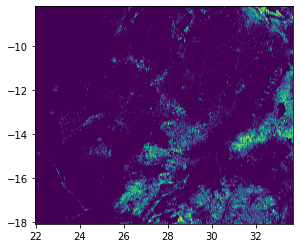

<AxesSubplot:>

In [7]:
show(f)

In [8]:
points = gdf[["lon", "lat"]].to_numpy()

In [9]:
class CustomDataset(Dataset):
    def __init__(self, points, buffer=.005):
        self.points = points
        self.buffer = buffer

    def __len__(self):
        return self.points.shape[0]

    def __getitem__(self, idx):

        lon, lat = self.points[idx]
        
        point_geom = shapely.geometry.mapping(shapely.geometry.Point(lon, lat))

        with rasterio.Env():
            with rasterio.open(a, "r") as f:
                point_shape = shapely.geometry.shape(point_geom)
                mask_shape = point_shape.buffer(self.buffer).envelope
                mask_geom = shapely.geometry.mapping(mask_shape)
                try:
                    out_image, out_transform = rasterio.mask.mask(
                        f, [mask_geom], crop=True
                    )
                except ValueError as e:
                    if "Input shapes do not overlap raster." in str(e):
                        return None

        out_image = out_image.squeeze()
        out_image = torch.from_numpy(out_image).float()
        return out_image
# Create the dataset
dataset = CustomDataset(points)

In [10]:
img = dataset[1000]
img

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [11]:
crops = (img == 1).sum() / img.numel()
crops.item()

0.2879238426685333

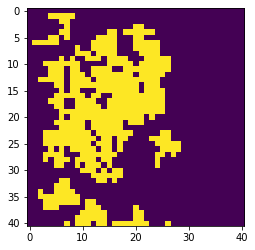

In [12]:
plt.figure()
plt.imshow(img)
plt.show()
plt.close()

In [13]:
dataloader = DataLoader(
    dataset,
    batch_size=8,
    shuffle=False,
    num_workers=os.cpu_count(), #*2,
    collate_fn=lambda x: x,
    pin_memory=False,
)

In [14]:
x_all = np.zeros((points.shape[0], 1), dtype=float)
tic = time.time()
i = 0
for image in dataset:

    # image = image.to(device)

    crops = (image == 1).sum() / image.numel()
    x_all[i] = crops.item()

    if i % 1000 == 0:
        print(
            f"{i}/{points.shape[0]} -- {i / points.shape[0] * 100:0.2f}%"
            + f" -- {time.time()-tic:0.2f} seconds"
        )
        tic = time.time()
    i += 1

0/15058 -- 0.00% -- 0.01 seconds
1000/15058 -- 6.64% -- 5.39 seconds
2000/15058 -- 13.28% -- 5.28 seconds
3000/15058 -- 19.92% -- 5.18 seconds
4000/15058 -- 26.56% -- 5.18 seconds
5000/15058 -- 33.20% -- 5.19 seconds
6000/15058 -- 39.85% -- 5.17 seconds
7000/15058 -- 46.49% -- 5.11 seconds
8000/15058 -- 53.13% -- 5.33 seconds
9000/15058 -- 59.77% -- 5.37 seconds
10000/15058 -- 66.41% -- 5.16 seconds
11000/15058 -- 73.05% -- 5.12 seconds
12000/15058 -- 79.69% -- 5.12 seconds
13000/15058 -- 86.33% -- 5.25 seconds
14000/15058 -- 92.97% -- 5.08 seconds
15000/15058 -- 99.61% -- 5.10 seconds


In [15]:
crops = pd.DataFrame({'crop_perc': x_all.squeeze()})
crops[["lon", "lat"]] = points.tolist()
# Save the crop_weights to a feather file
file_name = f'{taylor_data_dir}/weights/{country_code}_crop_weights_{len(points)/1000:0.0f}k-points.feather'
print("Saving file as:", file_name)
crops.to_feather(file_name)
print("Save finished!")

Saving file as: /capstone/cropmosaiks/data/weights/ZMB_crop_weights_15k-points.feather
Save finished!


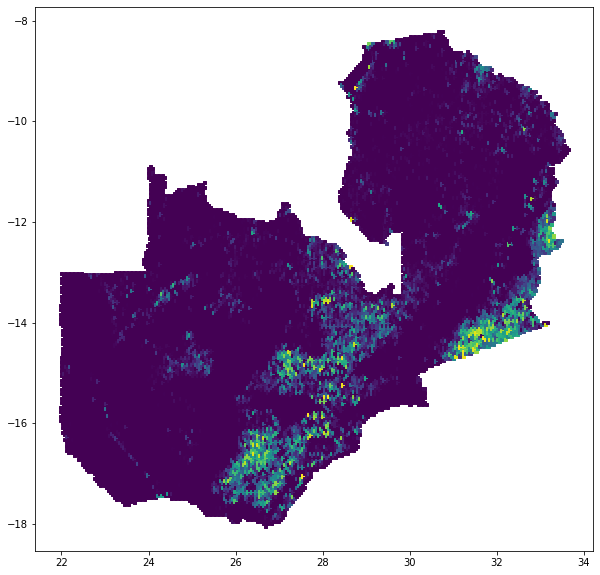

In [16]:
plt.figure(figsize = (10,10))
plt.scatter(
    crops.lon, 
    crops.lat, 
    c=crops.crop_perc, 
    s=10,
    marker = ','
)

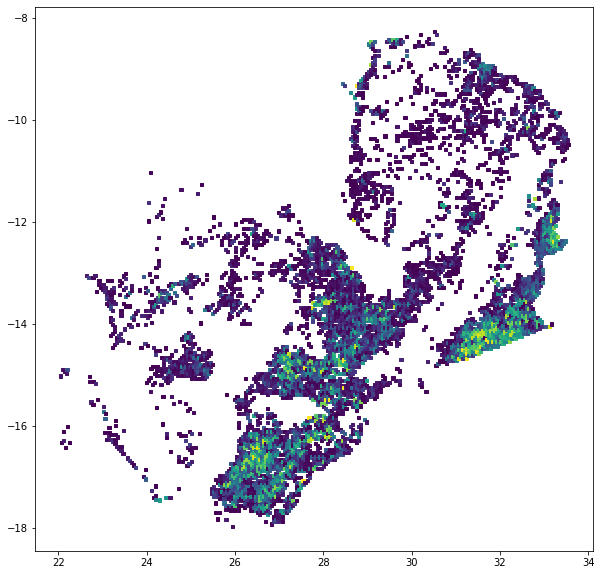

In [17]:
crops.replace(0, np.nan, inplace=True)
plt.figure(figsize = (10,10))
plt.scatter(
    crops.lon, 
    crops.lat, 
    c=crops.crop_perc, 
    s=10,
    marker = ','
)